# Typing time series transformations

## Problem statement
Time series data comes in many different forms: univariate or multivariate, a single instances or multiple instances. 

Correspondingly, there are many different forms of transformations that can be applied to time series data. 

This is an attempt to organise these transformations into categories with common APIs.

1. Find a taxonomy of time series transformations using scientific types based on input and output types
2. Develop transformer class structure/hierarchies in Python based on scitype taxonomy

In [1]:
from sktime.forecasting.all import *
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator
import typing
from typing import Union, NewType
import pandas as pd
import numpy as np

## Data types

### Primitives
* single or multiple primitives
* primitive types or 1d array 

In [2]:
# single or mulitple primitives
Primitive = Union[np.integer, int, np.float, float, str]
Primitives = np.ndarray

### Tabular
* scikit-learn-like data
* 2d arrays: rows represent instances, columns represent variables/features, cells contain Primitives

In [3]:
Tabular = Union[pd.DataFrame, np.ndarray]  # 2d arrays

### Series
* univariate or multivariate
* 1d or 2d arrays: rows represent time points, columns represent variables, cells represent observations
* observations are Primitives
* observations are ordered (usually in time)

In [4]:
# univariate or multivariate
UnivariateSeries = Union[pd.Series, np.ndarray]
MultivariateSeries = Union[pd.DataFrame, np.ndarray]
Series = Union[UnivariateSeries, MultivariateSeries]

In [5]:
def make_series(n_timepoints=10, n_variables=1):
    assert n_timepoints > 1
    assert n_variables > 0
    index = pd.date_range("2020-01-01", periods=n_timepoints, freq="D")
    if n_variables == 1:
        return pd.Series(np.random.lognormal(size=n_timepoints), index=index, name="Data")
    else:
        return pd.DataFrame(np.random.lognormal(size=(n_timepoints, n_variables)), index=index)

In [6]:
y = make_series(n_timepoints=10)
Y  = make_series(n_timepoints=10, n_variables=3)
y_train, y_test = temporal_train_test_split(make_series(n_timepoints=20))

### Series-as-features
* panel/longitudinal data with multiple instances of univariate/multivariate Series (and potentially Primitives)
* nested/3d arrays, potentially also awkward array: rows represent instances, columns represent variables/features, 3rd dimension represents time points

In [7]:
SeriesAsFeatures = Union[pd.DataFrame, np.ndarray]

## Transformation types

### 1. Series -> Primitives
* encapsulated in functions - not classes - because not fittable, so no parameters have to be stored (not stateful)
* may have tuneable arguments (e.g. which quantile to extract), which can be exposed in comopsitions via FunctionTransformer
* optionally, wrapped in classes for convenience

#### Examples:
* mean
* quantile

In [8]:
def series_to_primitive(x: Series, **kwargs) -> Primitives:
    # non-fittable
    pass

In [9]:
# example
def quantile(x, q=0.5):
    # non-fittable
    return np.quantile(x, q, axis=0)

In [10]:
quantile(y)

0.7227260461650926

In [11]:
quantile(Y)

array([0.8209263 , 0.89320774, 1.9748594 ])

In [12]:
# turn functions into classes for model composition 
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(quantile)
transformer.fit_transform(y)

0.7227260461650926

#### Aside: Callable transformers
Optionally, we can create callable transformers, but not sure if they add much. 

In [13]:
# alternatively, base class with __call__
class _SeriesToPrimitivesTransformer(BaseEstimator):
    
    def __init__(self, **kwargs):
        self.func = None
        self.kwargs = kwargs
        self._fixed_kwargs = None
    
    def __call__(self, X: Series, q=0.5) -> Primitives:
        # call function with kwargs
        # ignore kwargs passed to __init__
        return self.func(X, q, **self._fixed_kwargs)
    
    def fit(self, X: Series, y=None):
        # empty fit
        return self
    
    def transform(self, X: Series, y=None) -> Primitives:
        return self.func(X, **self.kwargs)
    
    def fit_transform(self, X: Series, y=None) -> Primitives:
        return self.fit(X, y).transform(X, y)
    
    def inverse_transform(self, X: Series, y=None) -> Primitives:
        # any examples of inverse transform? 
        # all series -> primitive transforms seem lossy 
        raise NotImplementedError("abstract method")

In [14]:
# example
class QuantileTransformer(_SeriesToPrimitivesTransformer):
    
    def __init__(self, q=0.5):
        self.q = q
        self._fixed_kwargs = {"axis": 0}
        self.func = np.quantile
        
    def transform(self, X, y=None):
        return self.func(X, self.q, **self._fixed_kwargs)
    
    def fit_transform(self, X: Series, y=None) -> Primitives:
        return self.fit(X, y).transform(X, y)

In [15]:
# call, but not too useful, since we still have to instantiate the class
transformer = QuantileTransformer()
transformer(y, q=0.25)

0.4055988469076195

In [16]:
transformer = QuantileTransformer(q=0.25)
transformer.fit_transform(y)

0.4055988469076195

### 2. Series -> Series
* may be fittable (e.g. extract AR coefficients from series)
* if not fittable, encapsulated as functions, composable via FunctionTransformer, optionally wrapped in classes for convenience
* if fittable, encapsulated in classes
* input and output of transform may have different number of time points and different index
* input and output may have different domain (no longer on the same time line)
* in a forecasting pipeline, fit_transform is called before call fit of the final forecaster, and inverse_transform is called after calling predict of the final forecaster

#### Examples
* Box-Cox transform
* logarithm
* smoothing, filters
* detrender
* deseasonalisation 
* Change point annotator (e.g. returns sequence of change point waiting times)
* Adding holiday dummies 
* Adding Fourier terms

In [17]:
def series_to_series(x: Series, **kwargs) -> Series:
    # non-fittable
    pass

In [18]:
def fourier_transform(x): 
    return np.fft.fft(x, axis=0)

In [19]:
fourier_transform(y).shape

(10,)

In [20]:
fourier_transform(Y).shape

(10, 3)

In [21]:
# scikit-learn FunctionTransformer
transformer = FunctionTransformer(fourier_transform)
transformer.fit_transform(y).shape

(10,)

In [22]:
# bespoke class implementations
class _SeriesToSeriesTransformer(BaseEstimator):
    
    def fit(self, X: Series, y=None):
        # empty fit by default, but some series-to-series transformers 
        # are fittable (detrender)
        return self
    
    def transform(self, X: Series, y=None) -> Series:
        raise NotImplementedError("abstract method")
        
    def inverse_transform(self, X: Series, y=None) -> Series:
        raise NotImplementedError("abstract method")
    
    def fit_transform(self, X: Series, y=None) -> Series:
        return self.fit(X, y).transform(X, y)

In [23]:
# example
class LogTransformer(_SeriesToSeriesTransformer):
    
    def transform(self, X, y=None):
        return np.log(X)
    
    def inverse_transform(self, X, y=None):
        return np.exp(X)

In [24]:
transformer = LogTransformer()
transformer.fit_transform(Y)

,0,1,2
2020-01-01,-0.515835,0.372193,0.112130
2020-01-02,3.095066,-0.289596,0.809287
2020-01-03,-1.208329,-0.256039,0.950091
2020-01-04,2.042524,0.602140,-2.330337
2020-01-05,-0.122535,0.321508,-0.256482
2020-01-06,-0.096535,0.990142,0.698641
2020-01-07,-1.345440,0.012229,0.662018
2020-01-08,-1.484844,-0.621910,1.274051
2020-01-09,-0.235011,-0.462800,1.020862
2020-01-10,-0.161002,-0.879149,-0.091590


### Special case: Featurizer
In a forecasting pipeline, fit_transform is called before calling fit of the final forecaster and transform is called *before* calling predict of the final forecaster. So, Featurizers need to be aware of the forecasting horizon and need to be able to return transformed data even when y (forecasted values) are not available yet.

#### Option 1: Keep transformer API but change inner workings

In [25]:
# examples
from pmdarima.preprocessing.exog.fourier import _fourier_terms

def _get_index(X=None, y=None):
        assert X is not None or y is not None
        if X is None:
            return y.index
        else:
            return X.index

class HolidayFeaturizer(_SeriesToSeriesTransformer):
    
    def __init__(self, calendar=None):
        self.calendar = calendar
    
    def transform(self, X, y=None):
        index = _get_index(X, y)
        start, end = index[0], index[-1]
        holidays = self.calendar.holidays(start, end, return_name=True)
        if holidays.empty:
            return X
        
        Xt = pd.get_dummies(holidays.reindex(index))
        return pd.concat([X, Xt], axis=1)
    
class FourierFeaturizer(_SeriesToSeriesTransformer):
    
    def __init__(self, sp=None, k=None):
        self.sp = sp
        self.k = k
        
    def fit(self, X, y=None):
        index = _get_index(X, y)
        assert self.sp is not None
        if self.k is None:
            k = self.sp // 2
        else:
            k = self.k
            
        if 2 * k > self.sp or k < 1:
            raise ValueError("k must be a positive integer not greater "
                             "than sp//2")

        # Compute the periods of all Fourier terms. Since R allows multiple
        # seasonality and we do not, we can do this much more simply.
        p = ((np.arange(k) + 1) / self.sp).astype(np.float64)  # 1:K / m

        # If sinpi is 0... maybe blow up?
        # if abs(2 * p - round(2 * p)) < np.finfo(y.dtype).eps:  # min eps

        self.p_ = p
        self.k_ = k
        self.n_ = index.shape[0]
        self._start = index[0]
        self._cutoff = index[-1]
        return self
    
    def transform(self, X, y=None):
        index = _get_index(X, y)
        # extrapolate fourier terms 
        fh = ForecastingHorizon(index, is_relative=False)
        start = self._start
        cutoff = self._cutoff
        times = fh.to_absolute_int(start, cutoff).to_numpy(dtype=np.float64) + 1
        Xt = pd.DataFrame(_fourier_terms(self.p_, times), index=index)
        return pd.concat([X, Xt], axis=1)

In [26]:
# fitting 
from pandas.tseries.holiday import USFederalHolidayCalendar
y_train = make_series(100)
transformer = HolidayFeaturizer(calendar=USFederalHolidayCalendar())
transformer.fit_transform(None, y_train).head(3)

,Martin Luther King Jr. Day,New Years Day,Presidents Day
2020-01-01,0,1,0
2020-01-02,0,0,0
2020-01-03,0,0,0


In [27]:
# fitting 
X_train = None
t = FourierFeaturizer(sp=12, k=2)
Xt = t.fit_transform(X_train, y=y_train)
Xt.tail(3)

,0,1,2,3
2020-04-07,0.866026,0.499999,0.866024,-0.500002
2020-04-08,1.000000,-0.000001,-0.000003,-1.000000
2020-04-09,0.866025,-0.500001,-0.866027,-0.499997


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='3'>)

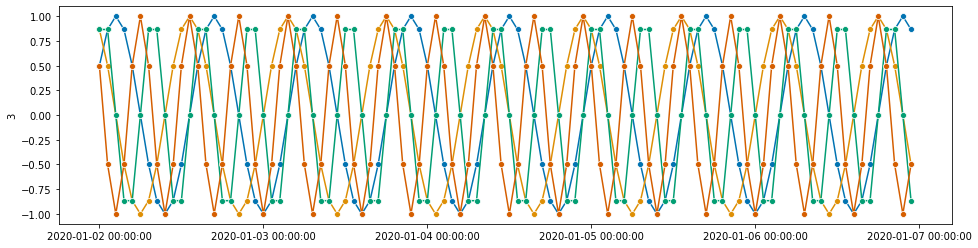

In [28]:
plot_series(*[Xt.iloc[:, i] for i in range(Xt.shape[1])])

In [29]:
# predicting
X_test = None
fh = ForecastingHorizon(y_test.index, is_relative=False)

# pre-initialised empty y_pred with fh as index
if X_test is None:
    X_test = pd.DataFrame(index=fh.to_absolute(t._cutoff).to_pandas(), dtype=np.float)
X_test = t.transform(X_test)
X_test.head(5)

,0,1,2,3
2020-01-16,8.660253e-01,-0.500000,-8.660256e-01,-0.500000
2020-01-17,4.999998e-01,-0.866026,-8.660252e-01,0.500000
2020-01-18,-2.622683e-07,-1.000000,5.245367e-07,1.000000
2020-01-19,-5.000002e-01,-0.866025,8.660257e-01,0.500000
2020-01-20,-8.660255e-01,-0.500000,8.660251e-01,-0.500001


#### Option 2: Add new Featurizer type and composition class

In [30]:
from sktime.forecasting.base._sktime import OptionalForecastingHorizonMixin
from sktime.forecasting.base._sktime import BaseSktimeForecaster

class _Featurizer(OptionalForecastingHorizonMixin, BaseSktimeForecaster):
    
    def fit(self, y, fh=None, X=None):
        self._set_fh(fh)
        self._set_y_X(y, X)
        self._is_fitted = True
        return self
        
    def predict(self, fh=None, X=None) -> Series:
        raise NotImplementedError("abstract method")
        
    def fit_predict(self, y, fh=None, X=None) -> Series:
        return self.fit(y, fh, X).predict(fh, X)

In [31]:
class HolidayFeaturizer(_Featurizer):
    
    def __init__(self, calendar=None):
        self.calendar = calendar
        self._features = None
        super(HolidayFeaturizer, self).__init__()
        
    def fit(self, y, fh=None, X=None):
        super(HolidayFeaturizer, self).fit(y, fh, X)
        assert self.calendar is not None
        assert isinstance(y.index, pd.DatetimeIndex)
    
    def predict(self, fh=None, X=None):
        self.check_is_fitted()
        self._set_fh(fh)
        fh = self.fh.to_absolute(self.cutoff).to_pandas()
        holidays = self.calendar.holidays(fh[0], fh[-1], return_name=True)
        
        return pd.get_dummies(holidays.reindex(fh, axis=0)).reindex(self._features, axis=1, fill_value=0)
    
    def fit_predict(self, y, fh=None, X=None):
        # additionally keeps track of holiday names, so that we generate the same features in fit and predict in pipeline
        self.fit(y, fh, X)
        X_pred = self.predict(fh, X)
        self._features = X_pred.columns
        return X_pred

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar
y_train = make_series(100)
featurizer = HolidayFeaturizer(calendar=USFederalHolidayCalendar())
featurizer.fit(y_train)
fh = ForecastingHorizon(y_train.index, is_relative=False)
X_pred = featurizer.predict(fh)
X_pred.head() # may return empty data frame

,Martin Luther King Jr. Day,New Years Day,Presidents Day
2020-01-01,0,1,0
2020-01-02,0,0,0
2020-01-03,0,0,0
2020-01-04,0,0,0
2020-01-05,0,0,0


In [33]:
from sklearn.base import clone

def _clone_estimators(estimators):
    return [(name, clone(estimator)) for name, estimator in estimators]

class FeaturizedForecaster(OptionalForecastingHorizonMixin, BaseSktimeForecaster):
    
    def __init__(self, estimators):
        self.estimators = estimators
        super(FeaturizedForecaster, self).__init__()
        
    def fit(self, y, fh=None, X=None):
        self._set_y_X(y, X)
        
        _check_estimators(self.estimators)
        self.estimators_ = _clone_estimators(self.estimators)
        
        xs = []
        # use in-sample forecasting horizon
        h = ForecastingHorizon(self._y.index, is_relative=False)
        for i, (name, featurizer) in self.featurizers_():
            # 1. fit featurizer
            x = featurizer.fit_predict(y, h, X)
            xs.append(x)
            self.estimators_[i] = (name, featurizer)
            
        X = pd.concat([X, *xs], axis=1)
        
        # 3. fit final forecaster
        name, forecaster = self.forecaster_
        forecaster.fit(y, fh, X)
        self.estimators_[-1] = (name, forecaster)
        
        self._is_fitted = True
        return self
    
    def predict(self, fh=None, X=None):
        self.check_is_fitted()
        
        xs = []
        for _, (_, featurizer) in self.featurizers_():
            # 3. generate features
            x = featurizer.predict(fh, X=X)
            xs.append(x)
        
        X = pd.concat([X, *xs], axis=1)
        
        # 3. fit final forecaster
        _, forecaster = self.forecaster_
        y_pred = forecaster.predict(fh, X)
        return y_pred
    
    @property
    def forecaster_(self):
        return self.estimators_[-1]
    
    def featurizers_(self):
        yield from enumerate(self.estimators_[:-1])


def _get_name(estimator):
    return estimator.__class__.__name__

def _check_estimators(estimators):
    assert isinstance(estimators, list)
    assert len(estimators) > 0
    
    for estimator in estimators:
        assert isinstance(estimator, tuple)
    
    names = [name for name, _ in estimators]
    assert len(set(names)) == len(names)
    
    return estimators
        
def make_featurized_forecaster(*estimators):
    return FeaturizedForecaster([(_get_name(estimator), estimator) for estimator in estimators])

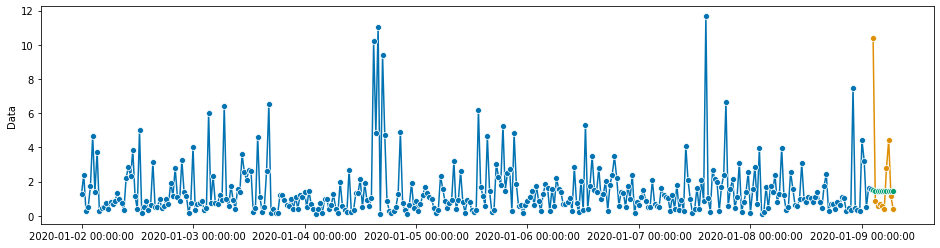

In [34]:
y = make_series(n_timepoints=365)
y_train, y_test = temporal_train_test_split(y, test_size=10)
forecaster = make_featurized_forecaster(
    HolidayFeaturizer(USFederalHolidayCalendar()), 
    AutoARIMA(suppress_warnings=True)
)
forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred);

In [35]:
_X = forecaster.estimators_[-1][-1]._X
assert _X.shape[0] == y_train.shape[0]
assert _X.shape[1] > 1
_X.head()

,Columbus Day,July 4th,Labor Day,Martin Luther King Jr. Day,Memorial Day,New Years Day,Presidents Day,Thanksgiving,Veterans Day
2020-01-01,0,0,0,0,0,1,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,0


### 3. Series-as-features -> Tabular
* usually fittable and encapsualted in classes
* input of fit and transform always needs to have the same number of columns and time points, but may have different number of instances
* input and output of transform always has the same number of instances, but may have different numbers of columns and time points

#### Examples
* Shapelet transform (returns minimum distance of each instance to found shapelets as tabular matrix)
* Feature extractors
* Tabularizer/TimeBinner
* composite transformers, e.g. applying series-to-primitives transform iteratively over instances/rows

In [36]:
class _SeriesAsFeaturesToTabularTransformer(BaseEstimator):

    def fit(self, X: SeriesAsFeatures, y=None):
        return self
        
    def transform(self, X: SeriesAsFeatures, y=None) -> Tabular:
        return Xt  # tabular

    def inverse_transform(self, X: SeriesAsFeatures, y=None) -> Tabular:
        return Xt  # tabular
    
    def fit_transform(self, X: SeriesAsFeatures, y=None) -> Tabular:
        return self.fit(X, y).transform(X, y)

In [37]:
# example
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor
from sktime.utils._testing import make_classification_problem

In [38]:
X, y = make_classification_problem()
X.columns = ["var"]
transformer = RandomIntervalFeatureExtractor()
Xt = transformer.fit_transform(X)
Xt.head()

,var_9_20_mean,var_3_9_mean,var_14_20_mean,var_10_16_mean
0,0.116812,0.000086,-0.029055,0.100015
1,20.017252,20.182154,19.928215,19.921868
2,19.769234,19.845818,19.773196,19.703131
3,19.966402,19.966789,20.028251,20.000857
4,19.826926,20.375101,20.082541,19.875460


### 4. Series-as-features -> Series-as-features
* usually fittable and encapsualted in classes
* input of fit and transform always needs to have the same number of columns and time points, but may have different number of instances
* input and output of transform always has same number of instances, but may have different numbers of columns and time points (including going from time-homogeneous data to time-heterogenous data)

#### Examples
* dictionary-based transforms 
* time series segmentation, e.g. splitting a time series columns into multiple ones, see IntervalSegmenter
* time series concatenation, e.g. merging multiple time series columns into a single one, see ColumnConcatenator
* composite transformers, e.g. applying series-to-series or series-to-primitive transforms iteratively over instances/rows

In [39]:
class _SeriesAsFeaturesToSeriesAsFeaturesTransformer(BaseEstimator):

    def fit(self, X: SeriesAsFeatures, y=None):
        return self
        
    def transform(self, X: SeriesAsFeatures, y=None) -> SeriesAsFeatures:
        return Xt  # tabular

    def inverse_transform(self, X: SeriesAsFeatures, y=None) -> SeriesAsFeatures:
        return Xt  # tabular
    
    def fit_transform(self, X: SeriesAsFeatures, y=None) -> SeriesAsFeatures:
        return self.fit(X, y).transform(X, y)

In [40]:
# example
from sktime.transformers.series_as_features.segment import RandomIntervalSegmenter

In [41]:
transformer = RandomIntervalSegmenter(n_intervals=3)
Xt = transformer.fit_transform(X)
Xt.head()

[[ 5 17]
 [ 3 10]
 [ 5 14]]


,var_5_17,var_3_10,var_5_14
0,"[0.7203988740564458, -0.06800861165484698, 0.4...","[-0.16191850458475052, -0.6427222098237795, 0....","[0.7203988740564458, -0.06800861165484698, 0.4..."
1,"[19.758224695530394, 20.458404113507985, 20.58...","[20.37609102313985, 20.092585938106986, 19.758...","[19.758224695530394, 20.458404113507985, 20.58..."
2,"[19.791875850946795, 19.966437583678466, 19.78...","[20.08751167780982, 19.91302129016223, 19.7918...","[19.791875850946795, 19.966437583678466, 19.78..."
3,"[19.40407239825091, 19.46845647792172, 19.8866...","[21.11531008343991, 19.3941045734907, 19.40407...","[19.40407239825091, 19.46845647792172, 19.8866..."
4,"[20.606577939895164, 20.48166649524029, 20.772...","[20.003606197226855, 20.357174139006965, 20.60...","[20.606577939895164, 20.48166649524029, 20.772..."


### 5. Meta-transformers

In [42]:
# example
def make_instance_transformer(transformer, **kwargs):
    if isinstance(transformer, _SeriesToSeriesTransformer):
        return SeriesToSeriesInstanceTransformer(transformer, **kwargs)
    elif isinstance(transformer, _SeriesToPrimitivesTransformer):
        return SeriesToPrimitivesInstanceTransformer(transformer, **kwargs)
    else:
        raise TypeError("transformer type not supported")
        
from sklearn.base import clone
from sktime.utils.data_container import detabularize

def _from_nested_to_series(x):
    if x.shape[0] == 1:
        return x.iloc[0]
    else: 
        return pd.DataFrame(x.tolist()).T

def _make_column_names(columns, prefix):
    if len(prefix) > 0:
        prefix = prefix + "_"
    return [f"{prefix}{column}" for column in columns]
    
class _InstanceTransformer:
    
    def __init__(self, transformer, prefix="", check_transformer=True):
        self.transformer = transformer
        self.check_transformer = check_transformer
        self.prefix = prefix
        
    def _check_transformer(self):
        assert hasattr(self, "_supported_transformer_type")
        if self.check_transformer and not isinstance(self.transformer, self._supported_transformer_type):
            raise TypeError(f"transformer must be a {self._supported_transformer_type.__class__.__name__}")
        
    def fit(self, X, y=None):
        self._check_transformer()
        transformer = clone(self.transformer)
        self.transformer_ = transformer.fit(X, y)
        return self

class SeriesToPrimitivesInstanceTransformer(_InstanceTransformer, _SeriesAsFeaturesToTabularTransformer):
    _supported_transformer_type = _SeriesToPrimitivesTransformer
    
    def transform(self, X, y=None):
        Xt = np.zeros(X.shape)
        for i, (_, x) in enumerate(X.iterrows()):
            x = _from_nested_to_series(x)
            Xt[i] = self.transformer_.transform(x)
        return pd.DataFrame(Xt, columns=_make_column_names(X.columns, self.prefix))
    
class SeriesToSeriesInstanceTransformer(_InstanceTransformer, _SeriesAsFeaturesToSeriesAsFeaturesTransformer):
    _supported_transformer_type = _SeriesToSeriesTransformer
    
    def transform(self, X, y=None):
        Xt = None
        for i, (_, x) in enumerate(X.iterrows()):
            x = _from_nested_to_series(x)
            xt = self.transformer_.transform(x)
            Xt = pd.concat([Xt, detabularize(xt.T)], axis=1)
        Xt = Xt.T
        Xt.columns = _make_column_names(X.columns, self.prefix)
        return Xt

In [43]:
from sktime.datasets import load_basic_motions
X, _ = load_basic_motions(return_X_y=True)

In [44]:
transformer = make_instance_transformer(QuantileTransformer(q=.25), prefix="q25")
Xt = transformer.fit_transform(X)
Xt.head()

,q25_dim_0,q25_dim_1,q25_dim_2,q25_dim_3,q25_dim_4,q25_dim_5
0,-0.229348,-0.170838,-0.146205,-0.093884,-0.050604,-0.191763
1,-0.342918,-0.352173,-0.040077,-0.049272,-0.029297,-0.167792
2,-0.219758,-0.786313,-0.003134,-0.125179,-0.128508,-0.380197
3,-0.280183,-0.201187,-0.269531,-0.091886,-0.117188,-0.104537
4,-0.348184,-0.265133,-0.056743,-0.058594,-0.015980,-0.123847


In [45]:
transformer = make_instance_transformer(LogTransformer(), prefix="log")
Xt = transformer.fit_transform(X)
Xt.head()

/Users/mloning/.conda/envs/sktime-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mloning/.conda/envs/sktime-dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


,log_dim_0,log_dim_1,log_dim_2,log_dim_3,log_dim_4,log_dim_5
0,0 -2.536967 1 -2.536967 2 NaN 3...,0 -0.931323 1 -0.931323 2 NaN 3...,0 -0.595215 1 -0.595215 2 NaN 3...,0 -1.045361 1 -1.045361 2 NaN 3...,0 -3.730952 1 -3.730952 2 NaN 3...,0 -0.455891 1 -0.455891 2 -0.028265 3...
0,0 -0.973520 1 -0.973520 2 1.082810 3...,0 NaN 1 NaN 2 -0.029720 3...,0 NaN 1 NaN 2 NaN 3...,0 NaN 1 NaN 2 NaN 3 NaN 4 NaN ...,0 NaN 1 NaN 2 NaN 3...,0 NaN 1 NaN 2 NaN 3...
0,0 NaN 1 NaN 2 NaN 3...,0 -0.191565 1 -0.191565 2 NaN 3...,0 -3.420013 1 -3.420013 2 -0.190955 3...,0 -3.848720 1 -3.848720 2 NaN 3...,0 -2.099522 1 -2.099522 2 NaN 3...,0 -0.254839 1 -0.254839 2 -0.958348 3...
0,0 -1.238374 1 -1.238374 2 NaN 3...,0 -1.258323 1 -1.258323 2 NaN 3...,0 -1.543276 1 -1.543276 2 -1.377267 3...,0 NaN 1 NaN 2 -3.982231 3...,0 -2.595963 1 -2.595963 2 -4.829565 3...,0 NaN 1 NaN 2 -1.439526 3...
0,0 NaN 1 NaN 2 NaN 3 NaN 4 NaN ...,0 -0.969320 1 -0.969320 2 -0.613410 3...,0 NaN 1 NaN 2 -1.568200 3...,0 NaN 1 NaN 2 NaN 3...,0 -2.837123 1 -2.837123 2 -1.738505 3...,0 NaN 1 NaN 2 -2.166962 3...


## Pipelining

### Forecasting
* implement ForecastingPipeline for exogenous transformations
* implement TransformedTargetForecaster for endogenous transformations

In [46]:
from sktime.forecasting.base._base import BaseForecaster
from sktime.forecasting.base._sktime import BaseSktimeForecaster
from sktime.forecasting.base._sktime import OptionalForecastingHorizonMixin

In [47]:
class ForecastingPipeline(OptionalForecastingHorizonMixin, BaseSktimeForecaster):
    
    def __init__(self, estimators):
        self.estimators = estimators
        super(ForecastingPipeline, self).__init__()
        
    def fit(self, y, X=None, fh=None):
        # even though this is a meta-estimator, we need to keep track of fh
        # and the cutoff to pre-initialise X in predict if no X is given
        self._set_y_X(y, X)
        self._set_fh(fh) 
        
        _check_estimators(self.estimators)
        
        # check and clone estimators 
        self.estimators_ = [(name, clone(estimator)) for name, estimator in self.estimators]
        
        # 1. transformations
        for i, name, transformer in self.transformers_():
            X = transformer.fit_transform(X, y)
            self.estimators_[i] = (name, transformer)

        # 2. fit final forecaster
        name, forecaster = self.forecaster_
        forecaster.fit(y, fh=fh, X_train=X)
        self.estimators_[-1] = (name, forecaster)
        
        self._is_fitted = True
        return self
    
    def predict(self, fh=None, X=None):
        self.check_is_fitted()
        self._set_fh(fh)
        
        # if no exogneous variables are given, we need to pre-initialise 
        if X is None:
            y_pred = pd.Series(index=self.fh.to_absolute(self.cutoff).to_pandas(), dtype=np.float)
        
        # 1. exogeneous transformations
        for _, _, transformer in self.transformers_():
            X = transformer.transform(X, y_pred)
        
        # 2. prediction
        _, forecaster = self.forecaster_
        y_pred = forecaster.predict(self.fh, X)
            
        return y_pred
    
    def transform(self, y=None, X=None):
        self.check_is_fitted()
        for i, name, transformer in self.transformers_():
            X = transformer.transform(X, y)
        return X
        
    @property
    def forecaster_(self):
        return self.estimators_[-1]
        
    def transformers_(self):
        transformers = self.estimators_[:-1]
        for i, (name, transformer) in enumerate(transformers):
            yield i, name, transformer
        
def make_pipeline(*estimators): 
    estimators = [(_get_name(estimator), estimator) for estimator in estimators]
    return ForecastingPipeline(estimators)

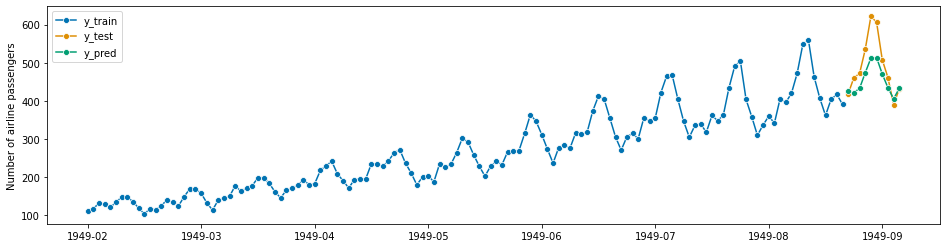

In [48]:
y = load_airline()
k = 6
y_train, y_test = temporal_train_test_split(y, test_size=10)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = make_pipeline(FourierFeaturizer(sp=12, k=k), AutoARIMA(seasonal=False, max_p=2, max_q=2, max_d=1, suppress_warnings=True))
forecaster.fit(y_train)

# tests
_data = forecaster.forecaster_[-1]._forecaster.model_.arima_res_.data
_X = _data.exog
assert _X.shape == (y_train.shape[0], k * 2), print(_X.shape)
_y = _data.endog
np.testing.assert_array_equal(_y, y_train)

y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [49]:
class TransformedTargetForecaster(BaseSktimeForecaster):
    
    def __init__(self, estimators):
        self.estimators = estimators
        
    def fit(self, y, fh=None, X=None):
        _check_estimators(self.estimators)
        self.estimators_ = [(name, clone(estimator)) for name, estimator in self.estimators]
        
        # 1. transform
        for i, name, transformer in self.transformers_():
            y = transformer.fit_transform(y)
            self.estimators_[i] = (name, transformer)
            
        # 2. fit final forecaster
        name, forecaster = self.forecaster_
        forecaster.fit(y, fh, X)
        self.estimators_[-1] = (name, forecaster)
        
        self._is_fitted = True
        return self
    
    def predict(self, fh=None, X=None):
        self.check_is_fitted()
        
        # 1. predict
        _, forecaster = self.forecaster_
        y_pred = forecaster.predict(fh, X)
        
        # 2. inverse-transform 
        for _, _, transformer in self.transformers_(reverse=True):
            y_pred = transformer.inverse_transform(y_pred)
            
        return y_pred
    
    def transformers_(self, reverse=False):
        transformers = self.estimators_[:-1]
        if reverse:
            transformers = reversed(transformers)
        for i, (name, transformer) in enumerate(transformers):
            yield i, name, transformer        
    
    @property
    def forecaster_(self):
        return self.estimators_[-1]

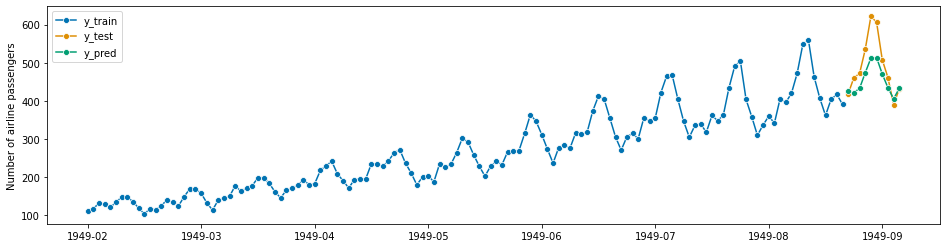

In [50]:
pipe = TransformedTargetForecaster([("log", LogTransformer()), ("forecaster", forecaster)])
pipe.fit(y_train)

# tests
_data = pipe.forecaster_[-1].forecaster_[-1]._forecaster.model_.arima_res_.data
_X = _data.exog
assert _X.shape == (y_train.shape[0], k * 2), print(_X.shape)
_y = _data.endog
np.testing.assert_array_equal(_y, np.log(y_train))

y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### Series-as-features setting
* use scikit-learn pipeline

In [51]:
from sklearn.pipeline import make_pipeline as make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [52]:
X, y = make_classification_problem(n_instances=500, n_columns=2)
X += 100
X_train, X_test, y_train, y_test = train_test_split(X, y)
classifier = make_pipeline(
    make_instance_transformer(LogTransformer()),
    make_instance_transformer(QuantileTransformer()), 
    DecisionTreeClassifier())
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[69,  0],
       [ 0, 56]])